Imports

In [ ]:
import numpy as np
import pandas as pd
import torch
import os
import pickle
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
#Use for GPUs
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from sklearn.metrics import accuracy_score, f1_score
import keras.backend as kback

In [ ]:
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


##Load dataset

Loading and splitting the dataset into training,validation and testing using tensorflow and keras

In [ ]:
(training_images, training_labels) , (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [ ]:
training_images, validation_images, training_labels, validation_labels = train_test_split(training_images, training_labels, test_size=0.15, random_state=42)

In [ ]:
print(training_images.shape)
print(validation_images.shape)
print(test_images.shape)

(42500, 32, 32, 3)
(7500, 32, 32, 3)
(10000, 32, 32, 3)


## Custom CNN class

**Intial proposed model to extract important channelwise features**

*The input image is passed through various convolutional layers and the convolved image is obtained. Channel-wise spatial information is extracted using global average pooling per channel for each convolved image. These channel wise information is concatenated or combined to form a vector that involves all the channel across the entire network. We propose to introduce an additional learnable linear layer that naturally abstracts most important channel wise information.  The channel wise spatial information is extracted from each convolution layer($c\times1$). This information is concatenated ($n\times c\times1$) and passed through a linear layer to extract information ($c\times1$).*

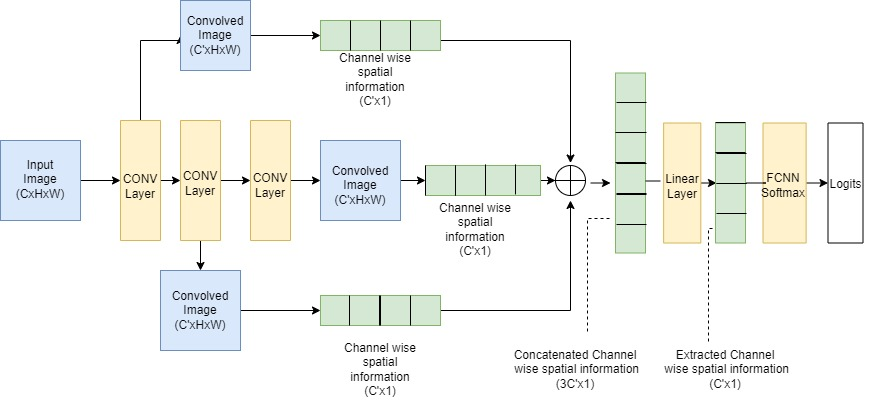

In [ ]:
class CustomModel(nn.Module):
    def __init__(self):
          super(CustomModel, self).__init__()
          self.convlayer1=nn.Conv2d(3,16,kernel_size=3,stride=1,padding=1)
          self.relu=nn.ReLU(inplace=True)
          self.convlayer2=nn.Conv2d(16,16,kernel_size=3,stride=1,padding=1)
          self.relu2=nn.ReLU(inplace=True)
          self.convlayer3=nn.Conv2d(16,16,kernel_size=3,stride=1,padding=1)
          self.relu3=nn.ReLU(inplace=True)
          self.AdaptiveAvgPooling=nn.AdaptiveAvgPool2d(1)   
          self.linear = nn.Linear(48,16)
          self.fc=nn.Linear(16,10)
          self.outputlayer = nn.Softmax(dim=0)

    def concatenate(self, tensor1, tensor2):
      return torch.cat((tensor1, tensor2), 0)
      
    def forward(self,image):
      convolved1=self.convlayer1(image)
      out1=self.relu(convolved1)
      convolved2=self.convlayer2(out1)
      out2=self.relu2(convolved2)
      convolved3=self.convlayer3(out2)
      out3=self.relu3(convolved3)
      adpavgpoolout3=self.AdaptiveAvgPooling(out3)
      adpavgpoolout2=self.AdaptiveAvgPooling(out2)
      adpavgpoolout1=self.AdaptiveAvgPooling(out1)
      combinedtensor=self.concatenate(adpavgpoolout1.squeeze(),adpavgpoolout2.squeeze())
      combinedtensor=self.concatenate(combinedtensor,adpavgpoolout3.squeeze())
      channelwiseop=self.linear(combinedtensor)
      opfc=self.fc(channelwiseop)
      logits=self.outputlayer(opfc)
      return logits     

In [ ]:
training_labels=training_labels.squeeze()

In [ ]:
model=CustomModel()

In [ ]:
learning_rate = 1e-3
epochs = 4
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

In [ ]:
def evaluate(model,images,labels,validate=False):
 predictions = []
 labels = []
 total_eval_loss=0
 model.eval()
 model=model.to(device)
 with torch.no_grad():
  for image,label in zip(images,labels):
      logits=model(image)
      loss = criterion(input = logits, target = label) 
      y_pred = torch.argmax(logits, dim=-1).item()
      total_eval_loss += loss.item()
      predictions.append(y_pred)
      labels.append(label)
  avg_val_loss = total_eval_loss / len(validation_labels)
  if validate:
    print("Validation Loss: {0:.2f}".format(avg_val_loss))
    print("Validation Accuracy: {0:.2f}".format(accuracy_score(predictions, labels))) 
    print("=========================")
  else:  
    print("Accuracy: {}".format(accuracy_score(predictions, labels)))
    print("F1 Score: {}".format(f1_score(predictions, labels)))
    print("=========================")
    with open('1e-3.pkl', 'wb') as f:
      pickle.dump(predictions, f) 

We have currently created an architecture. We will train the model with proper hyper paramaters and test it on CIFAR-10 dataset. We hypothesize that the proposed model will outperform the baselines as it uses information from previous layers and also extracts most important channel wise information that corresponds to better feature extraction and thus giving better classification results.

##Training

To Do:

In [ ]:
print("Training....")
'''for epoch in range(epochs):
    total_train_loss=0
    print("==========Epochs:{}===========".format(epoch)) 
    #Iterate over each image and label
    for image, label in zip(training_images,training_labels):
      #Pass image and get final logits
      image_data=torch.Tensor([image])
      image_data = image_data.permute(0, 3, 1, 2)
      logits = model(image_data)  
      one_hot = torch.zeros(10)
      one_hot[label] = 1
      loss = criterion(input = logits, target = one_hot)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_train_loss += loss 
    evaluate(model,validation_images,validation_labels,True)     
    #torch.save(model.state_dict(), "model"+epoch+".pth")
    print("Training Loss: {}".format((total_train_loss/len(training_labels)).item()))'''

##Testing

To Do:

In [ ]:
'''print("Testing....")
evaluate(model,test_images,test_labels)'''